# <font color='darkorchid'>Wilson Dam</font>
<font color = 'slategray' > This notebook provides analyzes simulates the operations at Wilson dam, using the Canteen package. </font>

by: John Kucharski | 12 July 2021


In [1]:
import sys
import typing
import datetime as datetime

import numpy as np
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt

In [2]:
sys.path.insert(0, '/Users/johnkucharski/Documents/source/canteen')
import src.data as data
import src.outlet as outlet
import src.reservoir as reservoir
import src.utilities as utilities
import src.operations as operations
import src.simulation as simulation
import src.optimization as optimization

## <font color = slategray> Data Location </font>
<font color = slategray> A global variables used to access simulation data defined here. </font>

In [3]:
data_folder: str = '/Users/johnkucharski/Documents/data/usace/ks/'

# <font color = salmon> Reservoir </font>

## <font color = slateblue> map: volume-elevation (rating curve) </font>
<font color = slategray> A lot of the Wilson dam and reservoir data is expressed in terms of elevation, instead of volume. As a result, the rating curve needs to be established first. Later on, I plot this data. </font> 

In [4]:
rating_path: str = data_folder + 'wilson_rating_curve.csv'

volumes = np.loadtxt(rating_path, skiprows=1, delimiter=',', usecols=[1])      #af
elevations = np.loadtxt(rating_path, skiprows=1, delimiter=',', usecols=[0])   #ft

f_rating = interpolate.interp1d(volumes, elevations, fill_value=(elevations[0], elevations[-1]), bounds_error=False)
inversef_rating = interpolate.interp1d(elevations, volumes, fill_value=(volumes[0], volumes[-1]), bounds_error=False)

rating_map = reservoir.Map(name='elevation', f=f_rating, inverse_f=inversef_rating)

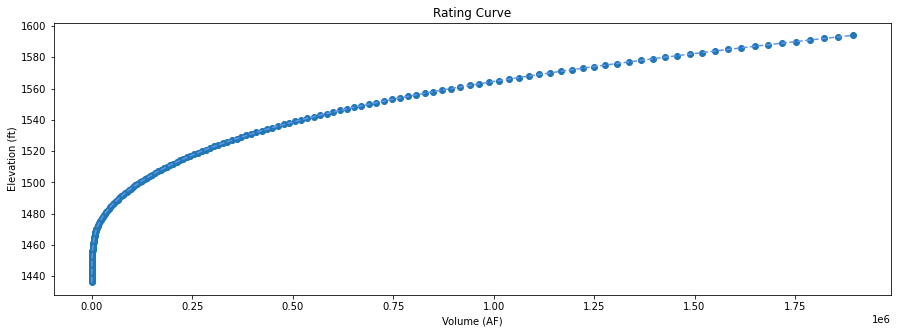

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
ax.scatter(volumes, elevations)
ax.plot(volumes, f_rating(volumes), color='cornflowerblue', linestyle='dashed')
ax.set_title('Rating Curve')
ax.set_xlabel('Volume (AF)')
ax.set_ylabel('Elevation (ft)')
plt.show()

## <font color = slateblue> outlets </font>
<font color = slategray> The reservoir contains two outlets:
 - gate: a single release gate
 - spillway: a spillway with no operational control

In [6]:
gate_path = data_folder + 'wilson_outlets.csv'

elevations = np.loadtxt(gate_path, skiprows=1, delimiter=',', usecols=[0])   # ft
gate_max_cfs = np.loadtxt(gate_path, skiprows=1, delimiter=',', usecols=[1]) # cfs
spillway_cfs = np.loadtxt(gate_path, skiprows=1, delimiter=',', usecols=[2]) # cfs
emergency_cfs = np.loadtxt(gate_path, skiprows=1, delimiter=',', usecols=[3]) # cfs

gate_location, spillway_location, emergency_location = 1450.5, 1545.5, 1582.5
volumes = [inversef_rating(x) for x in elevations]
gate_max_af = [x * utilities.days_to_sec(1) * utilities.cf_to_af(1) for x in gate_max_cfs]
spillway_af = [x * utilities.days_to_sec(1) * utilities.cf_to_af(1) for x in spillway_cfs]
emergency_af = [x * utilities.days_to_sec(1) * utilities.cf_to_af(1) for x in emergency_cfs]

gate = outlet.Outlet('gate', gate_location, utilities.f_interpolate_from_data(volumes, gate_max_af, extrapolate_lo=0, extrapolate_hi=gate_max_af[-1]))
spillway = outlet.Outlet('spillway', spillway_location, utilities.f_interpolate_from_data(volumes, spillway_af, extrapolate_lo=0, extrapolate_hi=spillway_af[-1])) 
emergency = outlet.Outlet('emergency_spillway', emergency_location, utilities.f_interpolate_from_data(volumes, emergency_af, extrapolate_lo=0)) #Note: this will return nan above data range.

wilson_outlets = [gate, spillway, emergency]

<font color = slategray> The following block of code constructs a Canteen _reservoir_ object, for Wilson Dam.

In [7]:
wilson = reservoir.Reservoir(capacity=float(inversef_rating(1592)), outlets=wilson_outlets, maps={rating_map})
wilson.print()

'default(capacity: 1821585.0, outlets: [emergency_spillway(location: 1582.0), spillway(location: 1546.0), gate(location: 1450.0)], mapped variables: [elevation])'

# <font color = salmon> Operations </font>

<font color = 'slategray'>Wilson reservoir operations in this workbook are based on those found in the 2021 Hydrologic Engineering Center Reservoir Simulation (HEC-RESSIM) model of the Kansas River Reservoirs Flood and Sediment Study. To run a simulation in the Canteen package, all the operations are contained in a single **operate()** function. However, for clarity the componentized HEC-RESSIM model set up is followed below.</font>

## <font color = slateblue>Pools</font>

<font color = slategray>In the HEC-RESSIM model, operational rules are defined for the following zones: 
<ol>
<li> inactive (no operations) pool</li>
<li> conservation pool </li>
<li> flood pool, and </li> 
<li> surcharge space </li>
</ol>

In the HEC-RESSIM model releases above the top of the conservation pool/bottom of the flood pool is determined based on the storage in some of the Kansas River watershed system reservoirs. To reproduce that behavior here would require modeling the entire system, this beyond the scope of this assignment (and would not support the goals of this assignment). The operations here assume a constant top of conservation pool elevation of 1516 ft (as indicated in the HEC-RESSIM model).

The _active_zone()_ function in the next block of code, is used during the simulation to determine which zone of the reservoir is active. It returns an enum provided in the _operations_ module. 

In [8]:
top_inactive_elev_ft = 1440
top_conservation_elev_ft = 1516
surcharge_elevation_ft = 1554.5

def active_zone(input: data.Input) -> operations.Zone:
    if input.storage + input.inflow  < rating_map.inverse_f(top_inactive_elev_ft):
        return operations.Zone.INACTIVE
    elif rating_map.inverse_f(top_inactive_elev_ft) < input.storage + input.inflow < rating_map.inverse_f(top_conservation_elev_ft):
        return operations.Zone.CONSERVATION
    elif rating_map.inverse_f(top_conservation_elev_ft) < input.storage + input.inflow < rating_map.inverse_f(surcharge_elevation_ft):
        return operations.Zone.FLOOD
    else:
        return operations.Zone.SURCHARGE

<font color=slategray> Next operations for each of these pools are defined as seperate functions. All of these operations could be defined in one large function, but this componentization of the code more closely matches the way these rule are defined in the HEC-RESSIM model. Each function takes two arguments: 

1. input (_input.Input_): inputs for a single timestep in the simulation. This input object contains at a minimum:

    * _Input.date_: a date for the simulation timestep, 
    * _Input.storage_: the reservoir storage volume leading into the timestep, and
    * _Input.inflow_: the inflow volume into the reservoir in that timestep
    * optional _Input.additional_arguments_ are discussed later in the notebook.
<br/><br/>
2. outlets (List[outlet.Outlet]): a list of outlets from which the releases will be made, typically Reservoir.outlets

Each fuction returns a dictionary (_Dict[str, float]_) with keys matching the _Outlet.name_ attribute an the release volume values.

### <font color = salmon>INACTIVE ZONE
<font color=slategray> Within the inactive zone no releases are made.

In [9]:
def inactive_operations(input: data.Input, outlets: typing.List[outlet.Outlet] = wilson_outlets, factor: float = 1) -> typing.Dict[str, float]:
    return {x.name: 0.0 for x in outlets}
print(inactive_operations(data.Input(datetime.date(2020, 1, 1), 1, 1), wilson_outlets))

{'gate': 0.0, 'spillway': 0.0, 'emergency_spillway': 0.0}


### <font color = salmon> CONSERVATION POOL

<font color=slategray> A simple minimum release, defined as step function (based on time of year) is made from the conseration pool.

In [10]:
def conservation_operations(input: data.Input, outlets: typing.List[outlet.Outlet] = wilson_outlets, factor: float = 1) -> typing.Dict[str, float]:
    yr: int = input.date.year
    convert = utilities.days_to_sec(1) * utilities.cf_to_af(1)
    release = 15.0 * convert if datetime.date(yr, 4, 1) < input.date < datetime.date(yr, 10, 1) else 5.0 * convert    
    return  {x.name: (min(release * max(factor, 1), x.max_release(input.storage + input.inflow)) if x.name == 'gate' else 0.0) for x in outlets}  
print(conservation_operations(data.Input(datetime.date(2020, 1, 1), rating_map.inverse_f(1518), 1), wilson_outlets))     

{'gate': 9.917355371900825, 'spillway': 0.0, 'emergency_spillway': 0.0}


### <font color = salmon> FLOOD POOL

<font color=slategray> In the HEC-RESSSIM model flood operations depend on storage in other Kansas watershed system reservoirs. Functions for these operations are provided at the end of this workbook, but are beyond the scope (would require modeling the entire system) and needs of this study. For this reason, a simple flood pool rule is provided in the next code block.

In [11]:
def flood_operations(input: data.Input, outlets: typing.List[outlet.Outlet] = wilson_outlets, factor: float = 1):
    release = {}
    storage = input.storage + input.inflow 
    target = (storage - rating_map.inverse_f(top_conservation_elev_ft)) * factor
    for x in outlets:
        out = min(x.max_release(storage), target)
        storage, target = storage - out, target - out
        release[x.name] = out
    return release
print(flood_operations(data.Input(datetime.date(2020, 1, 1), rating_map.inverse_f(1550), 1), wilson_outlets))

{'gate': 6489.015732300253, 'spillway': 5643.449921240429, 'emergency_spillway': 0.0}


### <font color = salmon>SURCHARGE SPACE

<font color=slategray> In this pool the _flood_release()_ rules still apply. No rules are given for releases above 1588 ft (the top of dam is at 1592), operations at 1588 are assumed for the purposes of this model to extend to the top of dam. Above the top of dam outflow will be assumed to equal inflow.

In [12]:
def surcharge_operations(input: data.Input, outlets: typing.List[outlet.Outlet] = wilson_outlets, factor: float = 1):
    storage = input.storage + input.inflow
    emergency_release = outlet.select_outlet('emergency_spillway', outlets).max_release(storage)
    storage = storage - emergency_release
    spillway_release = outlet.select_outlet('spillway', outlets).max_release(storage)
    storage = storage - spillway_release
    releases = flood_operations(data.Input(input.date, inflow = 0, storage = storage), outlet.deselect_outlets(['spillway', 'emergency_spillway'], outlets))
    releases['spillway'] = spillway_release
    releases['emergency_spillway'] = emergency_release
    return releases
print(surcharge_operations(data.Input(datetime.date(2020, 1, 1), rating_map.inverse_f(1585), 1), wilson_outlets))

{'emergency_spillway': 9044.067258729357, 'spillway': 14538.506034737462, 'gate': 0.0}


## <font color = slateblue>operate() function</font>

<font color = slategray>The canteen package requires an _operate_ function (mentioned above). This function needs to match the signature of the release functions defined above. It takes: 

1. input (_input.Input_), and 
2. outlets (_List[outlet.Outlet]_) arguments. 

It returns a _Dict[str, float]_ containing _Outlet.name_ keys and release volume value pairs. This can be a single function containing the reservoir's operational rules. 

Wilson dam's operational rules are defined above across multiple functions (namely: _inactive_operations()_, _conservation_operations()_, _flood_operations()_, _surcharge_operations()_). In particular, a single function is defined for each of the reservoir's active zones. The active zones are in turn defined by the _active_zone()_ function. 

The _operations_ module contains an _Operations_ base class that contains the required _operate()_ function. Its constructor, accepts a list of rules, matching the _operate()_ function's signature. The _Wilson_Operations_ subclass below inherits from the _Operations_ base class, its constructor takes the _active_zone()_ function as an arguement, in addition to the rules required by baseclass. The _active_zone()_ function and operational rules are used to define the _operate()_ function logic.

In [13]:

wilson_rules = [inactive_operations, conservation_operations, flood_operations, surcharge_operations] 
class Wilson_Operations(operations.Rules):
    def __init__(self, rules: typing.List[typing.Callable[[data.Input, typing.List[outlet.Outlet]], typing.Dict[str, float]]] = wilson_rules,
                 wilson_active_zone: typing.Callable[[data.Input], operations.Zone] = active_zone) -> None:
        self.active_zone = wilson_active_zone
        super().__init__(rules)
    
    @property
    def rules(self):
        return super().rules
    
    def operate(self, input: data.Input, outlets: typing.List[outlet.Outlet], factor: float = 1) -> typing.Dict[str, float]:
        zone = self.active_zone(input)
        if zone == operations.Zone.INACTIVE:
            return self.rules[0](input, outlets, factor)
        elif zone == operations.Zone.CONSERVATION or factor == 0:          
            return self.rules[1](input, outlets, factor)
        elif zone == operations.Zone.FLOOD:
            return self.rules[2](input, outlets, factor)
        else: #zone == operatins.Zone.SURCHARGE
            return self.rules[3](input, outlets, factor)
              
wilson_ops = Wilson_Operations(wilson_rules)
print(wilson_ops.operate(data.Input(datetime.datetime(2021, 9, 3), 100), wilson_outlets))

{'emergency_spillway': nan, 'spillway': 14717.355371900825, 'gate': 0.0}


# <font color = salmon> Water Quality </font>

<font color = slategray> The central goal of Wilson example it to model a water quality metric. In this case, the concentration of salinity, as a function of the reservoir operations. Secondary and tertiary goals include: 

* evaluating salinity under a variety of plausible inflows, and
* optimizing the operations with respect to the salinity metric, given other operating constraints.

The Wilson Dam salinity data is very poor (nearly unusable). The 'salinity_concentration' function below is a flexible continious formulation of the salinity concentration with respect to inflows, $f(x, b, a) = \frac{b}{(1 + x^{a})}$, where $x$ is reservoir inflow, $b$ is the concentration for minimum flow conditions, and $a$ controls the rate at which the concentration trends toward $0$ for increasing flow volumes. Using the default formulation, the function is: $f(x) = \frac{1.7}{1 + x^1}$.

Given the quality of the salinity data, it may make sense to evaluate a range of possible salinity functions.

In [14]:
def salinity_concentration(input: data.Input, base_concentration: float = 1.7, decay: float = 1) -> typing.Dict[str, float]:
    '''
        A rational function used to estimte percent salinity of reservoir inflows. 
        The highest concentration, 1.7% by default occurs with minimal flows, the concentration asymptotes toward 0 with increasing flow values.

        Args:
            input [data.input]: the input, containing the input inflow for a single timestep.
            base_concentration [float]: the maximum concentration, 1.7 percent by default.
            decay [float]: controls the rate a which the estimated concentation trends toward zero with increasing flow values, 1 by default (<1 for slower decay, >1 for faster decay).
        Returns:
            A dictionary with a single key: 'concentration' and single float value representing the salinity concentration as a percent.
    '''
    return {'concentration': 0} if input.inflow == 0 else {'concentration': 1.7 / (1 + input.inflow**decay)}

# <font color = salmon> Simulation </font>

<font color = 'slategray'>A simulation is run by the _Simulation_ class. This class is constructed using the _Simultion() constructor, which accepts the following arguments:

1. a list of data **inputs**: _List[input.Input]_ (described below)    
2. **wilson**: _Reservoir_ object (described above), 
3. **wilson_ops**: _operate()_ function (also described above), and
4. _additional_outputs_: _Dict[str, Additional_Output]_ (described below)
</font>


## <font color = slateblue>Input</font>

<font color = slategray>The inputs for a simulation are provided as a list of inputs (e.g. _List[inputs.Input]_). Each _Input_ item in this list serves as the input for a timestep in the simulation model. An _Input_ contains at a minimum:

1. _date_: a _datetime.date_ for the simulation timestep. </li>
2. _inflow_: an inflow volume at the _Reservoir_ during the simulation timestep. </li>
3. _storage_: an storage volume in the reservoir at the beginning of timestep. </li> 
4. _additional_arguments_: an optional _Dict[str, Any]_ of input key, value pairs described below. </li>

In this case the _date_ and _inflow_ parameters for the list of _Input_ are taken from the _dam_inflows.csv_ data. The simulation is initialized with the _Input.storage_ value equivalent to the top of conservation pool volume. Each subsquent _Input.storage_ value is updated within the _simulate()_ function, so the the np.nan value is used to initialize those _Input.storage_ values. A function for importing the _dam_inflows.csv_ data, and generating the _storage_ values is presented and run below. Then the first 5 _Input_ values, from this data files are displayed below.

In [15]:
def import_wilson_csv(path: str, initial_storage: float) -> pd.DataFrame:
    df = pd.read_csv(path, header=0, names=['_', 'date', 'inflow_cfs', '__'], skiprows=[1, 2, 3], skipinitialspace=True, 
                     usecols=['date', 'inflow_cfs'], dtype={'inflow_cfs': float}, parse_dates=True)
    df.dropna(axis='rows', inplace=True)
    df.reset_index(drop=True, inplace =True)
    df['date'] = pd.to_datetime([x.rsplit(',', maxsplit=1)[0] for x in df['date'].to_list()])
    df['inflow_af'] = [(x * utilities.days_to_sec(1) * utilities.cf_to_af(1)) for x in df.inflow_cfs.to_numpy()]
    df['storage_af'] = np.concatenate(([initial_storage], np.full(df.shape[0] - 1, np.nan)))
    df.drop(columns=['inflow_cfs'], inplace=True)
    return df
wilson_input_data = import_wilson_csv(data_folder + 'dam_inflows.csv', rating_map.inverse_f(top_conservation_elev_ft))
wilson_input_data.head()

,date,inflow_af,storage_af
0,1919-08-30,35.702479,236188.0
1,1919-08-31,35.702479,NaN
2,1919-09-01,35.702479,NaN
3,1919-09-02,35.702479,NaN
4,1919-09-03,43.636364,NaN


<font color=slategray>The following code block packages this input data into the list required for the simulation constructor (descirbed above);

In [16]:
wilson_inputs = [data.Input(date=row['date'], inflow=row['inflow_af'], storage=row['storage_af'], update_storage=True) for _, row in wilson_input_data.iterrows()]

## <font color = slateblue>Additional Outputs</font>

<font color = slategray> The _additional_outputs_ argument allows the user to *injecting* the reservoir simulation with one or more functions or models. In this case, a water quality model that produces a salinity concentration output is run during the reservoir simulation.

The _additional_outputs_ argument is input as a dictionary with string labels (keys) and Additional_Output (value) pairs. The _Additional_Output_ object is constructed using the _Additional_Output()_ constructor, which takes the following arguments:

1. _fn_: _Callable[[input,...], Dict[str, Any]]_ function, such as "model.run()" that accepts the Simulation.input argument and returns a dictionary of of labeld outputs (in the form _Dict[str, Any]_). 

In this case, _fn_ is the _salinity_concentration()_ function that returns a float value representing the reservoir salinity concentration, with the label (key) 'concentration'. (_note_: this somewhat awkward return value makes it possible to store multiple outputs from a single _fn_ function).

2. _is_outflow_: a boolean with a default value of 'False' that determines if the return values from the function should be subtracted out of the reservoir volume as an outflow (or not). 

For example, _is_outflow_ would allow a evaporation model to be included as _fn_ input, that returns generates evaporation amounts which are subtracted from the reservoir storaage values.

3. _run_order_: a Enum [BEFORE_OPERATIONS, BEFORE_STORAGE, AFTER_STORAGE] with a default value of AFTER_STORAGE that determines when in the simulation process the _fn_ function should be called.

In [17]:
wilson_additional_output = simulation.Additional_Output(salinity_concentration, run_order=simulation.Run_Order.BEFORE_OPERATIONS)

# <font color=salmon>Running Simulation

<font color=slategray> The following code block constructs the _Simulation_ object and runs the simulation using the _simulate_to_dataframe()_ command, which calls the _simulate()_ function and returns the output in the form of a _pandas.DataFrame_.

In [18]:

wilson_simulation = simulation.Simulation(wilson_inputs, wilson, wilson_ops.operate, {'salinity': wilson_additional_output})
outputs = wilson_simulation.simulate_to_dataframe()
outputs.head()

,inflow,storage,emergency_spillway,spillway,gate,total_release,salinity_concentration
date,,,,,,,
1919-08-30,35.702479,236188.0,0.0,0.0,35.702479,35.702479,0.046318
1919-08-31,35.702479,236188.0,0.0,0.0,35.702479,35.702479,0.046318
1919-09-01,35.702479,236188.0,0.0,0.0,35.702479,35.702479,0.046318
1919-09-02,35.702479,236188.0,0.0,0.0,35.702479,35.702479,0.046318
1919-09-03,43.636364,236188.0,0.0,0.0,43.636364,43.636364,0.038086


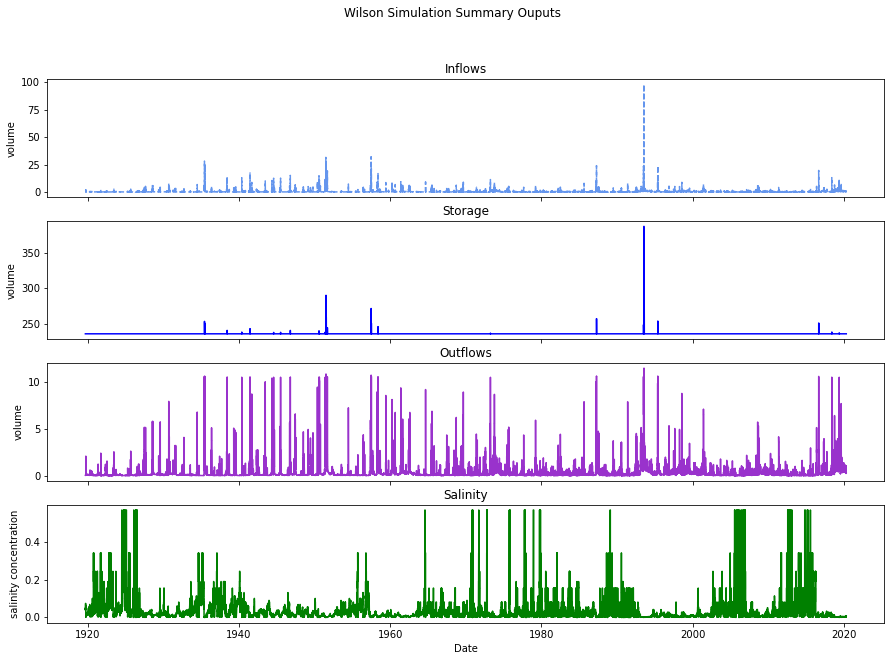

In [19]:
fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(15, 10))
plt.suptitle('Wilson Simulation Summary Ouputs')
ax[0].set_title('Inflows')
ax[0].set_ylabel('volume')
ax[0].step(outputs.index, outputs.inflow / 1000, where='post', color='cornflowerblue', linestyle='dashed', label='inflow')
ax[1].set_title('Storage')
ax[1].set_ylabel('volume')
ax[1].step(outputs.index, outputs.storage / 1000, where='post', color='blue', linestyle='solid', label='storage')
ax[2].set_title('Outflows')
ax[2].set_ylabel('volume')
ax[2].step(outputs.index, outputs.total_release / 1000, where='post', color='darkorchid', linestyle='solid', label='outflow')
ax[3].set_title('Salinity')
ax[3].set_ylabel('salinity concentration')
ax[3].step(outputs.index, outputs.salinity_concentration, where='post', color='green', linestyle='solid', label='salinity concentration')
ax[3].set_xlabel('Date')
plt.show()

# <font color=salmon> Optimization using PTreeOpt

<font color=slategray>The ptreeopt package is used to find operational rules that _minimize_ the _salinity concentration_ while preventing the reservoir from entering the _inactive pool_ or _surcharge space_. An _Optimizaiton_ object in the _canteen_ package stores data requred by the _ptreeopt_ optimiztion routines. 

## <font color=slateblue> Optimization

<font color = slategray>The optimization object constructor (_optimizaiton.Optimization()_) requires the following inputs:

1. _thresholds_: a _Dict[str, List[Any]]_ containing a string label (key) matching the name of a simulation output, and and a List[Any] (value) describing threshold values that correspond to optimization objectives. The _Optimizaiton_ object recognizes the following five types of threshold valuse:
    * A list with a single string value, either (1) 'min', or (2) 'max' indicating that the simulation output with the name matching the threshold string key should be minimized or maximized, respectively.

    * A list containing either a (3) '<', or '(4) >' string followed by a float value, _x_. The case, ['>', _x_] indicates that optimization routine will search for solutions in which value of the simulation output (with a name that matches the threshold key) exceeds the float value, _x_. The case, ['<', _x_] indicates the optimization routine will search for solution in whcih the value of the output does _not_ exceed the threshold, _x_.

    * (5) A list containing a minimim and maximum bound, in the form: ['minimum', 'maximum'], where 'minimum' and 'maximum' are float values. In this case the optimization routine will search for solutions in which the simulation output, with the same name as the threshold key, is on the range ['minimum', 'maximum'].

> In this case: the wilson reservoir salinity_concentration threshold is defined as _'salinity_concentration': ['min']_, and a storage constraint is defined using method (5) with the minimum set to the top of the inactive storage elevation and the maximum set to the bottom of surcharge space volume, below.

2. _indicators_: a OrderedDict[str, Tuple[float, float]] containing a string label matching a simulation input or output variable and range of variable values that the optimizaiton routine uses it trigger actions (described next). For instance, { 'storage': [100, 1000], 'inflow: [0, 100]}.

> In this case: indicators associated with the salinity concentration, inflow and storage are defined, in the code block below.

3. _actions_: a set of labels corresponding to operational rules implemented in a simulation or operations function.

> In this case: 10 actions modifying the release between the minimum release a double the typical release (given the active pool) are defined below. 

These threshold values are used to generate a penalty function, which increases when the thresholds are violated. The ptreeopt optimization routine then attempts to minimize this penalty function, by searching across many interations of the simulation() function for a set of operational rules and proposed actions, developed by adjusting indicator variables within their specified bounds, that results in the smallest penalty.

In [20]:
wilson_thresholds = {
    'salinity_concentration': ['min'],
    'storage': [inversef_rating(top_inactive_elev_ft), inversef_rating(spillway_location)], 
    #add release
}
wilson_indicators = {
    'salinity_concentration': [0, 2],
    'storage': [inversef_rating(top_inactive_elev_ft), inversef_rating(spillway_location)],
    'inflow': [0, 1500]
}
actions = [0, .1, .25, .5, .75, .9, 1, 1.25, 1.5, 2]
wilson_opt = optimization.Optimization(wilson_simulation, wilson_thresholds, wilson_indicators, actions)

In [21]:
import ptreeopt as ptree
algorithm = ptree.PTreeOpt(wilson_opt.optimize, 
                           feature_bounds = [[0, 2], [inversef_rating(top_inactive_elev_ft), inversef_rating(spillway_location)], [0, 1500]],
                           feature_names = ['salinity_concentration', 'storage', 'inflow'],
                           discrete_actions = True,
                           action_names = actions,
                           )

In [22]:
opt = algorithm.run(max_nfe = 10) 

/var/folders/3g/hp56fq4s45b9fjn9gjl80_gr0000gn/T/ipykernel_46957/3121341215.py:4: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  release = 15.0 * convert if datetime.date(yr, 4, 1) < input.date < datetime.date(yr, 10, 1) else 5.0 * convert


In [23]:
print(opt)

(<ptreeopt.tree.PTree object at 0x7f848108fee0>, 4238414894666829.0, {'nfe': [100], 'time': [602], 'best_f': [4238414894666829.0], 'best_P': [<ptreeopt.tree.PTree object at 0x7f848108fee0>]})


In [24]:
# (best solution, best score =obj function, disctionary or snapshots. = convergence and runtime stats)
print(opt[0])

inflow < 620, salinity_concentration < 1, 0.0 (91.87%), 0.5 (0.00%), 0.1 (8.13%)


In [25]:
import pickle
snapshots = opt
p = snapshots[2]['best_P'][0]

In [26]:
from ptreeopt.plotting import *
graphviz_export(p, 'test.svg')